# Домашняя работа 3: Разработка модели детектирования объектов

## Алексеев Илья


На семинаре мы обсудили, разработали и попробовали `SSD` модель на базе `VGG16`, поэтому для успешного выполнения домашнего задания рекомендуется обратиться к семинару.

Задачи домашнего задания:
 - Загрузить набор данных и визуализировать объекты. (2 балла)
 - Разработать функцию для расчета метрики mAP задачи детектирования объектов. Продемонстрировать работу. (4 балла)
 - Натренировать `SSD` модель на базе VGG16. Продемонстрировать повышение метрики mAP (4 балла)
 - Разработать `SSD` модель согласно предлагаемой архитектуры на базе `ResNet18`. Продемонстрировать повышение метрики mAP (10 баллов)
 - (БОНУС) Добавить разнообразные аугментации изображений. Можно позаимствовать из других репозитариев с указанием источника. Повторить эксперименты (5 баллов)

In [1]:
%load_ext autoreload
%autoreload 2

## Конфигурация детектора (пример для VGG16)

In [2]:
#VGG16
custom_config = {
 'num_classes'  : 3,
 'feature_maps' : [(90,160), (45,80), (23,40), (12,20), (10,18), (8,16)],
 'min_sizes'    : [0.10, 0.20, 0.37, 0.54, 0.71, 1.00],
 'max_sizes'    : [0.20, 0.37, 0.54, 0.71, 1.00, 1.05],
 
 'aspect_ratios': [[2, 3], [2, 3], [2, 3], [2, 3], [2], [2]],
 'num_priors'   : [6, 6, 6, 6, 4, 4], # number of prior boxes
 'variance'     : [0.1, 0.2],
 'clip'         : True,

 'overlap_threshold': 0.5, # IoU for NMS
 'neg_pos_ratio'    :   3, # hard-negative mining

 'model_name' : 'vgg16'
}


## Загружаем требуемый набор данных

### Make Validation Split

In [60]:
from src.dataset import VOCDetection

test_dataset = VOCDetection(
    path='data/dataset',
    split='Main/test'
)
len(test_dataset)

272

In [31]:
import random
import os

# read all names
path = 'data/dataset/ImageSets/Main/trainval.txt'
all_names = open(path, 'r').readlines()
n = len(all_names)
print(n)

# define train/val proportions
val_size = len(test_dataset)
train_size = n - val_size
print(train_size, val_size)

# shuffle and divide
random.seed(2)
random.shuffle(all_names)
train_names = all_names[:train_size]
val_names = all_names[:val_size]

# save
my_path = 'data/dataset/ImageSets/my_splits'
if not os.path.exists(my_path):
    os.makedirs(my_path)

train_path = os.path.join(my_path, 'train.txt')
val_path = os.path.join(my_path, 'val.txt')

open(train_path, 'w').writelines(train_names)
open(val_path, 'w').writelines(val_names)

5835
5563 272


In [61]:
val_dataset = VOCDetection(
    path='data/dataset',
    split='my_splits/val'
)
len(val_dataset)

272

In [33]:
from collections import defaultdict

def count_classes(dataset):
    res = defaultdict(int)
    for i in range(len(dataset)):
        _, _, labels = dataset[i]
        for i_class in labels.tolist():
            res[i_class] += 1
    return dict(res)

In [34]:
print('test counts:', count_classes(test_dataset))
print('val counts:', count_classes(val_dataset))

test counts: {2: 970, 1: 457}
val counts: {2: 958, 1: 470}


Я перебрал сиды, чтобы получить такие числа. Тест и валидация примерно соотносятся по количеству классов.

### Визуализация разметки

In [5]:
from src.dataset import VOCDetection

dataset = VOCDetection(
    path='data/dataset',
    split='my_splits/train'
)

In [6]:
def get_rect(bbox, image):
    scale_x, scale_y = image.size
    xmin, ymin, xmax, ymax = bbox
    anchor_x = xmin * scale_x
    anchor_y = ymin * scale_y
    size_x = (xmax - xmin) * scale_x
    size_y = (ymax - ymin) * scale_y
    return anchor_x, anchor_y, size_x, size_y

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def show_objects(i):
    image, boxes, labels = dataset[i]
    
    ax = plt.gca()
    ax.imshow(image)

    for bbox, label in zip(boxes, labels):
        anchor_x, anchor_y, size_x, size_y = get_rect(bbox, image)
        rect = patches.Rectangle((anchor_x, anchor_y), size_x, size_y, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.annotate(dataset.CLASSES[label], (anchor_x, anchor_y), color='lime')

    ax.axis('off')
    plt.tight_layout()
    plt.show()

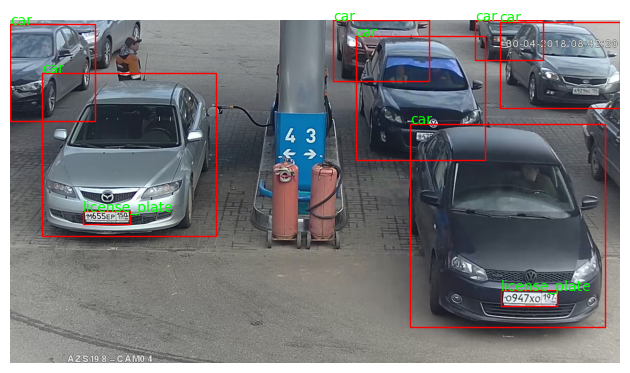

In [8]:
show_objects(7)

### DataLoaders

In [ ]:
from src.dataset import VOCDetection

train_dataset = VOCDetection(
    path='data/dataset',
    split='my_splits/train'
)

val_dataset = VOCDetection(
    path='data/dataset',
    split='my_splits/val'
)

In [ ]:
def collate_fn(batch):
    label_ss, box_ss, image_s = [], [], []

    for img, box, lab in batch:
        image_s.append(img)
        box_ss.append(box)
        label_ss.append(lab)

    return torch.stack(image_s), box_ss, label_ss

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=8,
    collate_fn=collate_fn,
    drop_last=True,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=8,
    collate_fn=collate_fn,
)

## Разработать функцию вычисления mAP метрики задачи детектирования

### mAP на случайных предсказаниях

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.boxes import generate_prior_boxes, Resnet18PriorBoxesConfig

config = Resnet18PriorBoxesConfig()
prior_boxes = generate_prior_boxes(config)

/home/ilya/repos/object-detection/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
prior_boxes.shape

torch.Size([2282, 4])

In [3]:
from src.boxes.conversion import to_corners_form

def get_rect2(bbox):
    """the same but bbox now in a center-offset format"""
    xmin, ymin, xmax, ymax = to_corners_form(bbox)[0].unbind()
    anchor_x = xmin
    anchor_y = ymin
    size_x = (xmax - xmin)
    size_y = (ymax - ymin)
    return anchor_x, anchor_y, size_x, size_y

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def show_priors(prior_boxes, n_boxes_to_show):
    ax = plt.gca()

    indices = np.random.choice(len(prior_boxes), n_boxes_to_show)

    for bbox in prior_boxes[indices]:
        anchor_x, anchor_y, size_x, size_y = get_rect2(bbox[None, :])
        rect = patches.Rectangle((anchor_x, anchor_y), size_x, size_y, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    ax.axis('off')
    plt.tight_layout()
    plt.show()

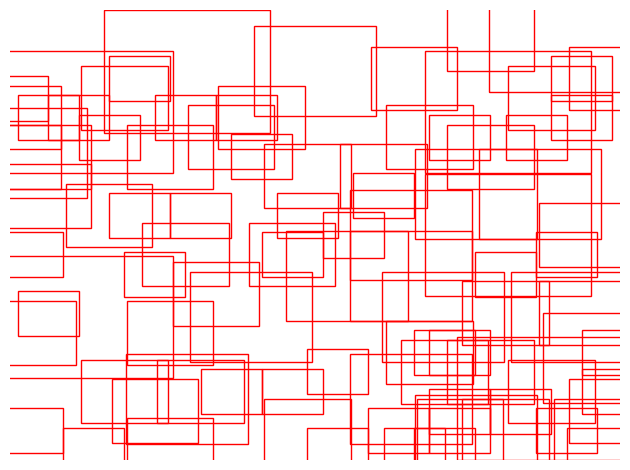

In [5]:
show_priors(prior_boxes, n_boxes_to_show=100)

In [8]:
import torch

# config
batch_size = 4
n_priors = prior_boxes.shape[0]

# generate boxes
cx = torch.empty(size=(batch_size, n_priors)).uniform_(0, 1)
cy = torch.empty(size=(batch_size, n_priors)).uniform_(0, 1)
w = torch.empty(size=(batch_size, n_priors)).uniform_(0, 0.4)
h = torch.empty(size=(batch_size, n_priors)).uniform_(0, 0.4)

# make valid
min_xdistance_to_edge = torch.min(cx, 1-cx)
min_ydistance_to_edge = torch.min(cy, 1-cy)
w = torch.minimum(w, min_xdistance_to_edge)
h = torch.minimum(h, min_ydistance_to_edge)

loc = torch.stack([cx, cy, w, h], dim=2)

# generate confidence scores
n_classes = 3
conf = torch.empty(size=(batch_size, n_priors, n_classes)).uniform_(0, 1)

In [9]:
from src.dataset import VOCDetection
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as T

ordinary_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.4824, 0.4495, 0.3981], std=[0.2765, 0.2691, 0.2825]),
])

dataset = VOCDetection(
    path='data/dataset',
    split='my_splits/val',
    transform=ordinary_transforms
)

def collate_fn(batch):
    label_ss, box_ss, image_s = [], [], []

    for img, box, lab in batch:
        image_s.append(img)
        box_ss.append(box)
        label_ss.append(lab)

    return torch.stack(image_s), box_ss, label_ss 

loader = DataLoader(
    dataset=dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

/home/ilya/repos/object-detection/.venv/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [10]:
images, boxes, labels = next(iter(loader))
print('images:', images.shape)
print('boxes length', len(boxes))
print('labels length', len(labels))
print('one box shape', boxes[0].shape)
print('one label shape', labels[0].shape)


images: torch.Size([4, 3, 720, 1280])
boxes length 4
labels length 4
one box shape torch.Size([8, 4])
one label shape torch.Size([8])


In [11]:
from src import detect_objects

detected_loc, detected_labels, detected_conf = detect_objects(
    loc, conf, prior_boxes, n_classes, overlap_threshold=0.5, conf_threshold=0.33
)

In [12]:
print('objects detected on pic 0:', loc[0].shape[0])

objects detected on pic 0: 2282


In [20]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
metric_fn = MeanAveragePrecision()

preds = []
for loc, lab, conf in zip(detected_loc, detected_labels, detected_conf):
    preds.append({
        'boxes': loc.cuda(),
        'scores': conf.cuda(),
        'labels': lab.cuda()
    })
target = []
for loc, lab in zip(boxes, labels):
    target.append({
        'boxes': loc.cuda(),
        'labels': lab.cuda()
    })
metric_fn(preds=preds, target=target)

/home/ilya/repos/object-detection/.venv/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


{'map': tensor(0.0005),
 'map_50': tensor(0.0050),
 'map_75': tensor(0.),
 'map_small': tensor(0.0005),
 'map_medium': tensor(-1.),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.),
 'mar_10': tensor(0.0033),
 'mar_100': tensor(0.0200),
 'mar_small': tensor(0.0200),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([1, 2], dtype=torch.int32)}

In [16]:
from src.boxes import mAP

mAP(
    predictions=(detected_loc, detected_labels, detected_conf),
    targets=(labels, boxes),
    threshold=.5,
    n_classes=3,
    interpolation='maximum',
    reduce=True
)

0.008953078226642243

## Натренировать модель на основе VGG16

### Load Weights

Я обучал в колабе с помощью скрипта `train.py`.

In [43]:
# import urllib

# google_drive_link = 'https://drive.google.com/file/d/10NmUnd35tc2PgK4jceWQnrCOwq_ZMaRU/view?usp=sharing'
# ! pip install -U gdown
# ! gdown --id {urllib.parse.urlparse(google_drive_link).path.split('/')[-2]} -O data/weights_vgg16.ckpt

/home/ilya/repos/object-detection/.venv/lib/python3.9/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=10NmUnd35tc2PgK4jceWQnrCOwq_ZMaRU
From (redirected): https://drive.google.com/uc?id=10NmUnd35tc2PgK4jceWQnrCOwq_ZMaRU&confirm=t&uuid=d17677c5-88bc-487c-8af2-050e87b75254
To: /home/ilya/repos/object-detection/data/weights_vgg16.ckpt
100%|████████████████████████████████████████| 115M/115M [00:30<00:00, 3.76MB/s]


### Inference

In [1]:
from src.models import SSD_VGG16
from src.boxes import VGG16PriorBoxesConfig

model = SSD_VGG16(
    n_priors_list=[2, 2, 2, 2, 2],
    n_classes=3
)
model.load_checkpoint('data/weights_vgg16.ckpt', VGG16PriorBoxesConfig())

/home/ilya/repos/object-detection/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.dataset import VOCDetection
import torchvision.transforms.v2 as T

ordinary_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.4824, 0.4495, 0.3981], std=[0.2765, 0.2691, 0.2825]),
])

train_dataset = VOCDetection(
    path='data/dataset',
    split='my_splits/train',
    transform=ordinary_transforms
)
print(len(train_dataset))

val_dataset = VOCDetection(
    path='data/dataset',
    split='Main/test',
    transform=ordinary_transforms
)
print(len(val_dataset))

5563
272


/home/ilya/repos/object-detection/.venv/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [3]:
def collate_fn(batch):
    label_ss, box_ss, image_s = [], [], []

    for img, box, lab in batch:
        image_s.append(img)
        box_ss.append(box)
        label_ss.append(lab)

    return torch.stack(image_s), box_ss, label_ss

In [4]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    drop_last=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [6]:
import torch

locations = []
classes = []

with torch.no_grad():
    for batch in val_loader:
        images = batch[0].cuda()
        boxes = [box.cuda() for box in batch[1]]
        labels = [lab.cuda() for lab in batch[2]]
        
        loc, clf = model(images)
        locations.append(loc.cpu())
        classes.append(clf.cpu())
    

In [7]:
locations = torch.concat(locations, dim=0)
classes = torch.concat(classes, dim=0)
torch.save(locations, 'data/preds_vgg16/test_locations.pt')
torch.save(classes, 'data/preds_vgg16/test_classes.pt')

### mAP

In [1]:
from src.boxes import generate_prior_boxes, VGG16PriorBoxesConfig

prior_boxes = generate_prior_boxes(VGG16PriorBoxesConfig)

/home/ilya/repos/object-detection/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

locations = torch.load('data/preds_vgg16/test_locations.pt', map_location='cpu')
classes = torch.load('data/preds_vgg16/test_classes.pt', map_location='cpu')

In [3]:
from src import detect_objects

detected_loc, detected_labels, detected_conf = detect_objects(
    locations, classes, prior_boxes, 3, overlap_threshold=0.1, conf_threshold=0.6
)

In [5]:
from src.dataset import VOCDetection
import torchvision.transforms.v2 as T

ordinary_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.4824, 0.4495, 0.3981], std=[0.2765, 0.2691, 0.2825]),
])

val_dataset = VOCDetection(
    path='data/dataset',
    split='Main/test',
    transform=ordinary_transforms
)
print(len(val_dataset))

272


In [6]:
boxes = []
labels = []
for _, loc, lab in val_dataset:
    boxes.append(loc)
    labels.append(lab)

In [7]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
metric_fn = MeanAveragePrecision()

preds = []
for loc, lab, conf in zip(detected_loc, detected_labels, detected_conf):
    preds.append({
        'boxes': loc.cuda(),
        'scores': conf.cuda(),
        'labels': lab.cuda()
    })
target = []
for loc, lab in zip(boxes, labels):
    target.append({
        'boxes': loc.cuda(),
        'labels': lab.cuda()
    })
metric_fn(preds=preds, target=target)

{'map': tensor(0.0842),
 'map_50': tensor(0.2756),
 'map_75': tensor(0.0236),
 'map_small': tensor(0.0842),
 'map_medium': tensor(-1.),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.0817),
 'mar_10': tensor(0.1755),
 'mar_100': tensor(0.1819),
 'mar_small': tensor(0.1819),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([1, 2], dtype=torch.int32)}

In [8]:
from src.boxes import mAP

mAP(
    predictions=(detected_loc, detected_labels, detected_conf),
    targets=(labels, boxes),
    threshold=.5,
    n_classes=3,
    interpolation='trapezoid',
    reduce=True
)

0.6464347775013635

Честно, я не понял, почему моя метрика сильно выше, чем в `torchmetrics` map_50. С ResNet18 тоже такая разница.

### Visualize Predictions

In [1]:
import torch

locations = torch.load('data/preds_vgg16/test_locations.pt', map_location='cpu')
classes = torch.load('data/preds_vgg16/test_classes.pt', map_location='cpu')

In [2]:
from src.boxes import generate_prior_boxes, VGG16PriorBoxesConfig

prior_boxes = generate_prior_boxes(VGG16PriorBoxesConfig)

/home/ilya/repos/object-detection/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from src.boxes import detect_objects

pred_boxes_all, pred_labels_all, pred_conf_all = detect_objects(
    locations,
    classes,
    prior_boxes,
    num_classes=3,
    overlap_threshold=0.1,
    conf_threshold=.7
)

In [4]:
from src.dataset import VOCDetection

val_dataset = VOCDetection(
    path='data/dataset',
    split='Main/test',
)

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def _get_rect(bbox, image):
    scale_x, scale_y = image.size
    xmin, ymin, xmax, ymax = bbox
    anchor_x = xmin * scale_x
    anchor_y = ymin * scale_y
    size_x = (xmax - xmin) * scale_x
    size_y = (ymax - ymin) * scale_y
    return anchor_x, anchor_y, size_x, size_y

def _draw(ax, boxes, labels, image, linecolor, textcolor, lw, dataset):
    for bbox, label in zip(boxes, labels):
        anchor_x, anchor_y, size_x, size_y = _get_rect(bbox, image)
        rect = patches.Rectangle((anchor_x, anchor_y), size_x, size_y, linewidth=lw, edgecolor=linecolor, facecolor='none')
        ax.add_patch(rect)
        ax.annotate(dataset.CLASSES[label], (anchor_x, anchor_y), color=textcolor)

def show_pred(i, dataset):
    image, true_boxes, true_labels = dataset[i]
    pred_boxes = pred_boxes_all[i]
    pred_labels = pred_labels_all[i]
    
    ax = plt.gca()
    ax.imshow(image)

    _draw(ax, pred_boxes, pred_labels, image, linecolor='r', textcolor='red', lw=1, dataset=dataset)
    _draw(ax, true_boxes, true_labels, image, linecolor='g', textcolor='green', lw=3, dataset=dataset)

    ax.axis('off')
    plt.tight_layout()
    plt.show()

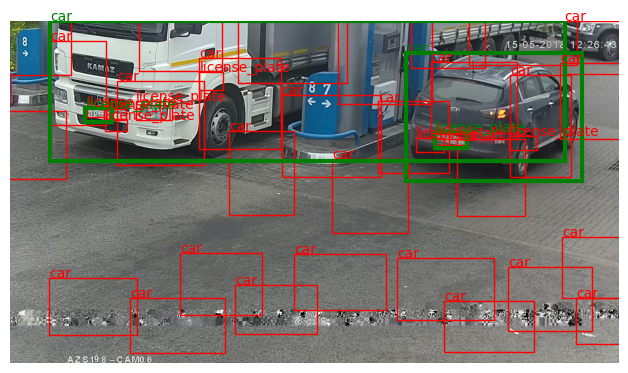

In [6]:
show_pred(3, val_dataset)

Эта модель сильно недообучена.

## Разработать модель на основе ResNet18

Как я собирал модель.
- конфиг можно посмотреть в файле `src/boxes/config.py`
- убрал все дополнительные aspect ratio (все мои якоря только 1:1)
- убрал фичер мапу с самым большим разрешением
- добавил в extra layers в пару мест макспулинг так, чтобы убрать фичермапы для среднего масштаба -- остались только для мелких деталей (авто номера) и больших объектов (автомобили)
- итоговые фичермапы: `[(23,40), (11,19), (2,4), (1,2), (1,2)]`
- Все описанные модификации вылились в число якорей: 2282. Это достаточно мало, но у меня была цель облегчить обучение

### Debug

In [1]:
from src.tests.resnet18 import test

test('my_resnet')

/home/ilya/repos/object-detection/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 6846, 4])
torch.Size([1, 6846, 3])


### Inference

In [7]:
from src.models import SSD_Resnet18
from src.boxes import Resnet18PriorBoxesConfig

model = SSD_Resnet18(
    n_priors_list=[2, 2, 2, 2, 2],
    n_classes=3
)
model.load_checkpoint('/home/ilya/repos/object-detection/logs/tb/resnet18-full/version_0/checkpoints/epoch=0-step=1390.ckpt', Resnet18PriorBoxesConfig())

In [8]:
from src.dataset import VOCDetection
import torchvision.transforms.v2 as T

ordinary_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.4824, 0.4495, 0.3981], std=[0.2765, 0.2691, 0.2825]),
])

val_dataset = VOCDetection(
    path='data/dataset',
    split='Main/test',
    transform=ordinary_transforms
)
print(len(val_dataset))

272


/home/ilya/repos/object-detection/.venv/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [9]:
def collate_fn(batch):
    label_ss, box_ss, image_s = [], [], []

    for img, box, lab in batch:
        image_s.append(img)
        box_ss.append(box)
        label_ss.append(lab)

    return torch.stack(image_s), box_ss, label_ss

In [10]:
from torch.utils.data import DataLoader

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [11]:
import torch

locations = []
classes = []

with torch.no_grad():
    for batch in val_dataloader:
        images = batch[0].cuda()
        boxes = [box.cuda() for box in batch[1]]
        labels = [lab.cuda() for lab in batch[2]]
        
        loc, clf = model(images)
        locations.append(loc.cpu())
        classes.append(clf.cpu())
    

In [12]:
path = 'data/preds_resnet18_full'
import os
if not os.path.exists(path):
    os.makedirs(path)
locations = torch.concat(locations, dim=0)
classes = torch.concat(classes, dim=0)
torch.save(locations, os.path.join(path, 'test_locations.pt'))
torch.save(classes, os.path.join(path, 'test_classes.pt'))

### mAP

In [1]:
from src.boxes import generate_prior_boxes, Resnet18PriorBoxesConfig

prior_boxes = generate_prior_boxes(Resnet18PriorBoxesConfig)

/home/ilya/repos/object-detection/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch

locations = torch.load('data/preds_resnet18_full/test_locations.pt', map_location='cpu')
classes = torch.load('data/preds_resnet18_full/test_classes.pt', map_location='cpu')

In [5]:
from src import detect_objects

detected_loc, detected_labels, detected_conf = detect_objects(
    locations, classes, prior_boxes, 3, overlap_threshold=0.1, conf_threshold=0.6
)

In [7]:
from src.dataset import VOCDetection
import torchvision.transforms.v2 as T

ordinary_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.4824, 0.4495, 0.3981], std=[0.2765, 0.2691, 0.2825]),
])

val_dataset = VOCDetection(
    path='data/dataset',
    split='Main/test',
    transform=ordinary_transforms
)
print(len(val_dataset))

272


In [8]:
boxes = []
labels = []
for _, loc, lab in val_dataset:
    boxes.append(loc)
    labels.append(lab)

In [10]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
metric_fn = MeanAveragePrecision()

preds = []
for loc, lab, conf in zip(detected_loc, detected_labels, detected_conf):
    preds.append({
        'boxes': loc.cuda(),
        'scores': conf.cuda(),
        'labels': lab.cuda()
    })
target = []
for loc, lab in zip(boxes, labels):
    target.append({
        'boxes': loc.cuda(),
        'labels': lab.cuda()
    })
metric_fn(preds=preds, target=target)

{'map': tensor(0.2822),
 'map_50': tensor(0.6905),
 'map_75': tensor(0.2104),
 'map_small': tensor(0.2822),
 'map_medium': tensor(-1.),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.1659),
 'mar_10': tensor(0.3733),
 'mar_100': tensor(0.3733),
 'mar_small': tensor(0.3733),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([1, 2], dtype=torch.int32)}

In [11]:
from src.boxes import mAP

mAP(
    predictions=(detected_loc, detected_labels, detected_conf),
    targets=(labels, boxes),
    threshold=.5,
    n_classes=3,
    interpolation='rectangle',
    reduce=True
)

0.9556605555944675

### Visualize Predictions

In [1]:
import torch
import os
path = 'data/preds_resnet18_full'

locations = torch.load(os.path.join(path, 'test_locations.pt'), map_location='cpu')
classes = torch.load(os.path.join(path, 'test_classes.pt'), map_location='cpu')

In [1]:
from src.boxes import generate_prior_boxes, Resnet18PriorBoxesConfig

prior_boxes = generate_prior_boxes(Resnet18PriorBoxesConfig)
prior_boxes.shape

/home/ilya/repos/object-detection/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([2282, 4])

In [3]:
from src.boxes import detect_objects

pred_boxes_all, pred_labels_all, pred_conf_all = detect_objects(
    locations,
    classes,
    prior_boxes,
    num_classes=3,
    overlap_threshold=0.2,
    conf_threshold=.7
)

In [4]:
from src.dataset import VOCDetection

val_dataset = VOCDetection(
    path='data/dataset',
    split='Main/test',
)

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def _get_rect(bbox, image):
    scale_x, scale_y = image.size
    xmin, ymin, xmax, ymax = bbox
    anchor_x = xmin * scale_x
    anchor_y = ymin * scale_y
    size_x = (xmax - xmin) * scale_x
    size_y = (ymax - ymin) * scale_y
    return anchor_x, anchor_y, size_x, size_y

def _draw(ax, boxes, labels, image, linecolor, textcolor, lw, dataset):
    for bbox, label in zip(boxes, labels):
        anchor_x, anchor_y, size_x, size_y = _get_rect(bbox, image)
        rect = patches.Rectangle((anchor_x, anchor_y), size_x, size_y, linewidth=lw, edgecolor=linecolor, facecolor='none')
        ax.add_patch(rect)
        ax.annotate(dataset.CLASSES[label], (anchor_x, anchor_y), color=textcolor)

def show_pred(i, dataset, save_path=None):
    image, true_boxes, true_labels = dataset[i]
    pred_boxes = pred_boxes_all[i]
    pred_labels = pred_labels_all[i]
    
    ax = plt.gca()
    ax.imshow(image)

    _draw(ax, pred_boxes, pred_labels, image, linecolor='r', textcolor='red', lw=1, dataset=dataset)
    _draw(ax, true_boxes, true_labels, image, linecolor='g', textcolor='green', lw=3, dataset=dataset)

    ax.axis('off')
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(os.path.join(save_path, f'{i}.jpg'), bbox_inches='tight')
        plt.clf()
    else:
        plt.show()


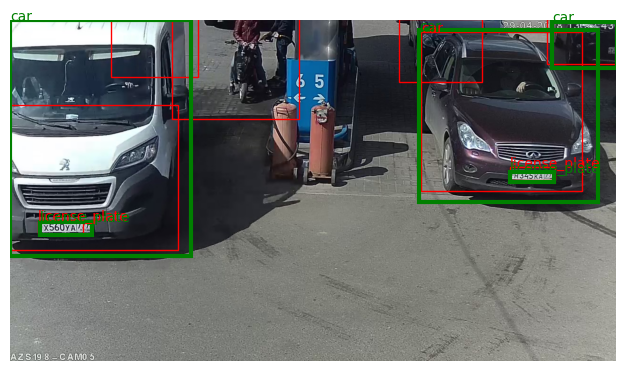

In [16]:
show_pred(30, val_dataset)

In [17]:
os.makedirs('data/preds_resnet18_full/img')

In [18]:
for i in range(len(val_dataset)):
    show_pred(i, val_dataset, save_path='data/preds_resnet18_full/img')

<Figure size 640x480 with 0 Axes>

Предсказания для всего тестового датасета: https://drive.google.com/file/d/1edazSimokkx2WTRaDZ8xvHfSvfPiep22/view?usp=sharing

## Итог

У меня не было цели обучить до упора.

Классная домашка!

Пара забавных детекций ниже.

Большой грузовик обнаружен не одним большим боксом, а тремя:

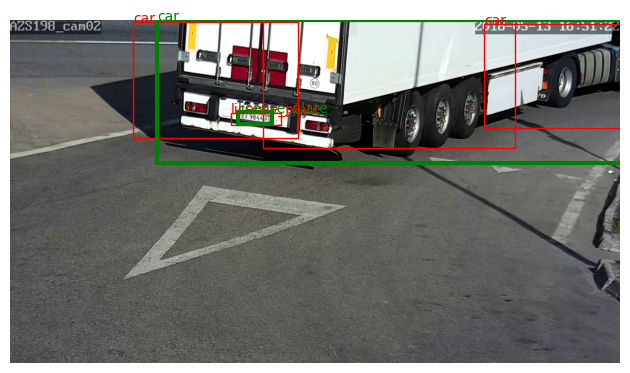

In [19]:
show_pred(247, val_dataset)

Грузовая часть машины не задетектилась, только перед:

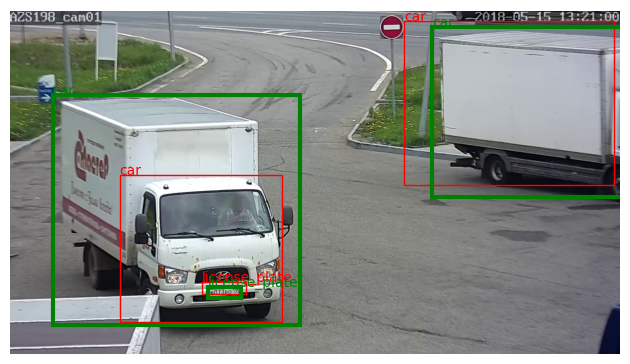

In [20]:
show_pred(1, val_dataset)

Тут детекция указала машину в правом верхнем углу, а на разметке ее нет (но могла бы быть так как логично)

А еще лого KAMAZ задетекчено как номерная плата

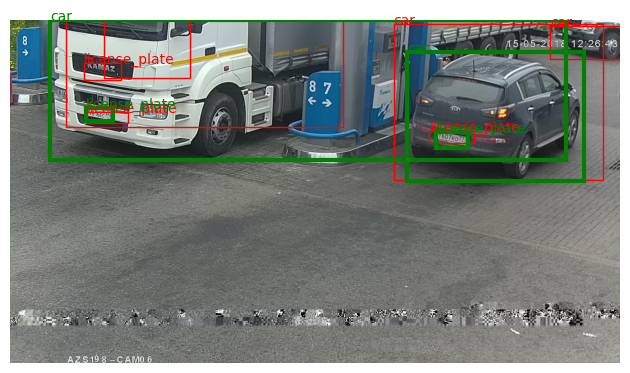

In [21]:
show_pred(3, val_dataset)

Отмечены мотоцицлы а не машины

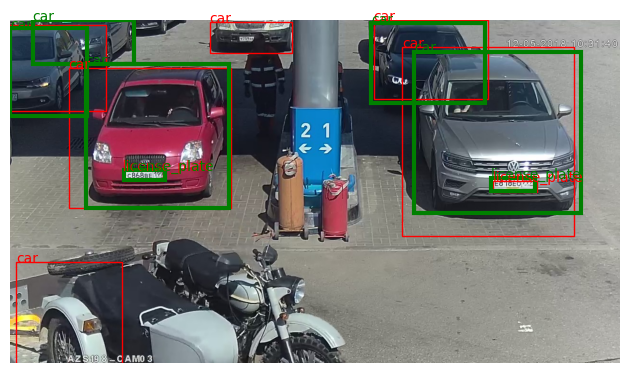

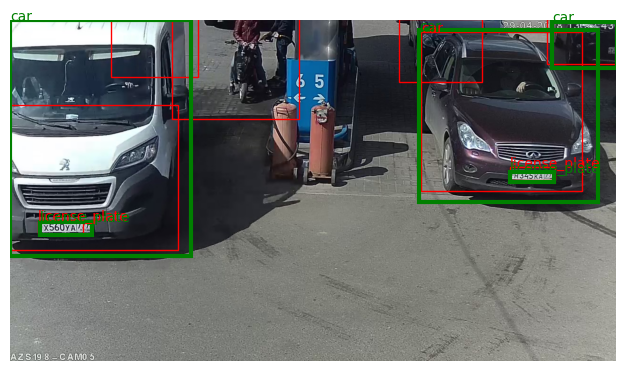

In [24]:
show_pred(19, val_dataset)
show_pred(30, val_dataset)

Детектор видит призраков

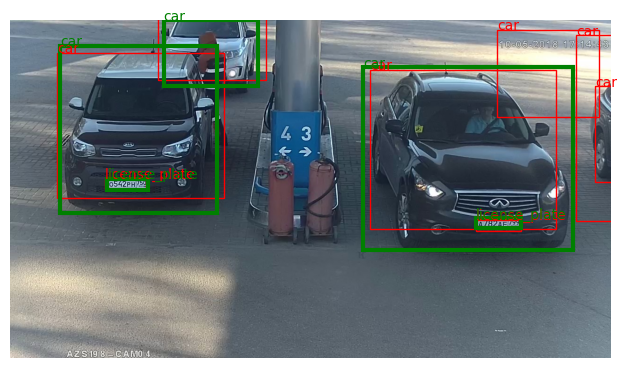

In [23]:
show_pred(26, val_dataset)